## 파이토치 기초 (2) - 신경망 모델 구현하기

* 지난 [pytorch 기초 - day1] 텐서와 Autograd (https://dacon.io/codeshare/4478) 에서 배운 개념을 바탕으로 간단한 신경망을 구현하겠습니다.


## 인공신경망 (ANN)

* 인공 신경망에서 자극을 입력받는 감각기관에 해당하는 부분을 입력층(input layer)이라 합니다.
* 입력층을 거친 자극은 은닉층(hidden layer)을 지나, 마지막 뉴런인 출력층(output layer)으로 전달됩니다. 
* 각 층에 존재하는 한 단위의 인공뉴런을 노드(node)라고 합니다.

* 신경세포가 자극을 전달하기 위해 화학적 처리를 가하듯, 인공신경망의 각 노드 역시 입력된 자극에 특정한 수학연산을 실행합니다.
* 바로 각 층에 존재하는 매개변수인 가중치(weight)에 행렬곱시키고 편향(bias)을 더해주는 것 입니다.
* 가중치는 입력 신호가 출력에 주는 영향을 계산한 매개변수이고, 편향은 각 노드가 얼마나 데이터에 민감한지 알려주는 매개변수입니다.
* 그리고 이 행렬곱의 결과는 활성화함수(activation function)을 거쳐 인공뉴런의 결괏값을 산출하게 됩니다.
* 활성화 함수는 입력에 적절한 처리를 해서 출력신호로 변환하는 함수로, 입력 신호의 합이 활성화를 일으키는지 아닌지를 정하는 역할을 합니다.
* 활성화 함수를 거친 결괏값은 은닉층의 인공뉴런으로 전달되고, 다시 한번 가중치 곱과 활성화 함수를 거치게 됩니다.
* 이런 뉴런 간의 자극 처리와 전달 과정을 반복한 후 마지막 출력층에서 결괏값을 만들어내는 것이 인공신경망의 기본적인 작동원리입니다.

* 물론 이것이 끝이 아니고, 우리는 인공 신경망의 출력층이 낸 결괏값과 정답을 비교해 오차를 계산해야 합니다.
* 이 오차를 기반으로 신경망 전체를 학습시키려면, 출력층의 가중치부터 입력층의 가중치까지 모두 경사하강법을 활용해 변경해주어야 합니다.
* 이렇게 겹겹이 쌓인 가중치를 뒤에서부터 차례대로 조정하고 최적화하는 알고리즘이 역전파(Backpropagation)알고리즘 입니다.

* 파이토치는 역전파 기법을 기본으로 제공하기 때문에, 우리가 직접 구현할 일은 없으나 딥러닝에서 가장 중요한 알고리즘이니 깊게 공부하고자 한다면 꼭 다시 살펴보길 권합니다.

In [1]:
# 간단한 분류모델 구현하기 #필요한 라이브러리 임포트
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

### 데이터 준비

In [2]:
# 신경망의 학습과 평가에 사용할 데이터셋을 만듭니다.
# sklearn의 make_blobs()함수를 이용하여 데이터를 2차원 벡터형태로 만들었습니다.
# 학습데이터셋에는 80개, 테스트데이터셋에는 20개의 2차원 벡터 데이터를 담았습니다.
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [3]:
# 이번에 학습시킬 신경망은 두 가지 레이블만 예측하는 매우 기본적인 모델이므로
# 4개의 레이블을 2개로 합쳐보겠습니다.
# label_map()함수로 0번이나 1번을 레이블로 가진 데이터는 전부 0번 레이블로, 2번이나 3번 레이블을 가진 데이터는 모두 1번레이블로 바꿉니다
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

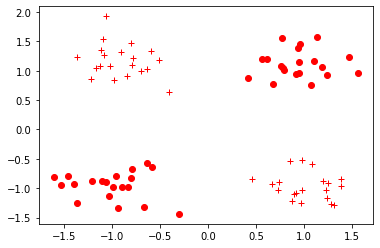

In [4]:
# 데이터가 제대로 만들어지고 레이블링 되었는지 확인하기 위해 맷플롯립으로 시각화합니다.
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+') # 레이블이 0인 데이터는 점으로, 1인 데이터는 '+'로 표현합니다

plt.figure()
vis_data(x_train, y_train, c='r')
plt.show()

In [5]:
# 방금 생성한 넘파이 벡터 형식 데이터를 파이토치 텐서로 바꿔줍니다.
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


### 신경망 모델 구현

In [6]:
class NeuralNet(torch.nn.Module): # 파이토치 신경망은 보통 신경망모듈 (torch.nn.Module)을 상속받는 파이썬 클래스로 정의합니다.
        def __init__(self, input_size, hidden_size):
            # init 함수는 파이썬에서 객체가 갖는 속성값을 초기화하는 역할로, 객체가 생성될 때 자동으로 호출됩니다.
            super(NeuralNet, self).__init__()
            # super() 함수를 부르면 우리가 만든 Neural Net 클래스는 파이토치의 nn.Module 클래스의 속성들을 가지고 초기화 됩니다.
            self.input_size = input_size # input size는 신경망에 입력되는 데이터의 차원입니다.
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor): #함수에서 정의한 동작을 차레대로 실행하는 함수입니다.
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1) # relu는 입력값이 0보다 작으면 0, 0보다 크면 입력값을 그대로 출력합니다.
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

In [7]:
# 신경망 객체 생성 및 변수와 알고리즘 정의
model = NeuralNet(2, 5) #input_size = 2, hidden_size = 5
learning_rate = 0.03
criterion = torch.nn.BCELoss() #이진 교차 엔트로피(binary cross entropy)를 뜻하는 BCELoss()함수를 사용합니다
epochs = 2000 # epoch은 전체 학습 데이터를 총 몇 번 모델에 입력할지 결정합니다.
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # 확률적 경사하강법 SGD를 선택합니다.

In [8]:
#아무 학습도 하지 않은 모델 성능 시험
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test) #모델의 결괏값과 레이블값의 차원을 맞추기 위해 squeeze()함수를 사용합니다
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7686280608177185


오차가 0.77정도 나왔습니다. 100번찍어 77번은 틀린다는 뜻으로, 사실상 분류하는 능력이 없다고 볼 수 있습니다. 
신경망을 학습시켜 성능을 개선하겠습니다.

In [9]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() #epoch마다 새로운 경삿값을 계산하기 위해 zero_grad() 함수를 호출하고 경삿값을 0으로 설정합니다.
    train_output = model(x_train) #학습 데이터를 입력해 결괏값을 계산합니다.
    train_loss = criterion(train_output.squeeze(), y_train) #결괏값의 차원을 레이블의 차원과 같게 만들고 오차를 계산합니다.
    if epoch % 100 == 0: #100 이폭마다 오차를 출력해 학습이 잘 되는지 확인하겠습니다.
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()  #오차 함수를 가중치로 미분하여 오차가 최소가 되는 방향을 구하고 그 방향으로 모델을 학습률만큼 이동합니다.

Train loss at 0 is 0.7390209436416626
Train loss at 100 is 0.6310345530509949
Train loss at 200 is 0.5371083617210388
Train loss at 300 is 0.44618287682533264
Train loss at 400 is 0.3667941391468048
Train loss at 500 is 0.3038358688354492
Train loss at 600 is 0.25539839267730713
Train loss at 700 is 0.21848437190055847
Train loss at 800 is 0.19018378853797913
Train loss at 900 is 0.1680794507265091
Train loss at 1000 is 0.15051519870758057
Train loss at 1100 is 0.13622190058231354
Train loss at 1200 is 0.12444063276052475
Train loss at 1300 is 0.11463527381420135
Train loss at 1400 is 0.10634960979223251
Train loss at 1500 is 0.0992763489484787
Train loss at 1600 is 0.09317845851182938
Train loss at 1700 is 0.08788712322711945
Train loss at 1800 is 0.08330424129962921
Train loss at 1900 is 0.07927173376083374


In [10]:
# 학습된 신경망의 성능 시험
model.eval()
test_loss = criterion(torch.squeeze(model(x_test)), y_test) #모델을 평가코드로 바꾸고 x_test와 y_test를 이용해 오차를 구합니다
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.0918821170926094


학습 전과 비교했을 때 오차가 현저히 줄어든 것을 확인할 수 있습니다!

In [11]:
# 학습된 모델을 .pt형태로 저장
torch.save(model.state_dict(), './model.pt') 
#state_dict()함수는 모델 내 가중치들이 딕셔너리 형태로 {연산 이름: 가중치 텐서와 편향 텐서}와 같이 표현된 데이터입니다.
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 1.5510, -1.3980],
        [ 0.5095, -0.4294],
        [ 0.4875, -0.5290],
        [-1.7940,  1.8137],
        [ 0.8072, -0.7266]])), ('linear_1.bias', tensor([-0.4568, -0.6786, -0.1410, -0.8228, -0.2257])), ('linear_2.weight', tensor([[2.1061, 0.0712, 0.3208, 2.5261, 1.0460]])), ('linear_2.bias', tensor([-2.8676]))])


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [12]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9847384691238403


새로운 모델에 벡터 [-1.1]을 입력해보면 레이블이 1일 확률이 98%나 되는 것을 알 수 있습니다.